In [4]:
import os
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage,SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
import uuid

In [5]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore


In [6]:
class State(TypedDict): 
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]


llm = ChatGroq(model="llama-3.1-8b-instant")

In [7]:

def generate_post(state: State): 
    """ Here, we're using the LLM to generate a LinkedIn post with human feedback incorporated """

    print("[generate_post] Generating content")
    linkedin_topic = state["linkedin_topic"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"]


    # Here, we define the prompt 

    prompt = f"""
    LinkedIn Topic: {linkedin_topic}
    Last Human Feedback: {feedback[-1] if feedback else "No feedback yet"}

    Generate a structured, engaging, and professional LinkedIn post around the topic. Refine the content using the given feedback.
    """
    response = llm.invoke([
        SystemMessage(content="You are an expert LinkedIn content writer"), 
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post = response.content

    print(f"[model_node] Generated post:\n{generated_linkedin_post}\n")

    return {
       "generated_post": [AIMessage(content=generated_linkedin_post)] , 
       "human_feedback": feedback
    }


In [13]:
def get_review_decision(state: State): 
    """Human Intervention node - loops back to model unless input is done"""

    print("\n [get_review_decision] awaiting human feedback...")

    generated_post = state["generated_post"]

    # Interrupt to get user feedback

    user_feedback = interrupt(
        {
            "generated_post": generated_post, 
            "message": "Provide feedback or type 'done' to finish"
        }
    )

    print(f"[get_review_decision] Received human feedback: {user_feedback}")

    # Extract the decision from the last message
    # If user types "done", transition to END node
    if user_feedback.lower() == "done": 
        return Command(update={
            "human_feedback": state["human_feedback"] + ["Finalised"]}, 
            goto="post")

    # Otherwise, update feedback and return to model for re-generation
    return Command(update={
        "human_feedback": state["human_feedback"] + [user_feedback]}, 
        goto="generate_post")




In [9]:
# def collect_feedback(state: State):   
#     feedback = input("How can I improve this post? ") 
#     return { 
#         "messages": [HumanMessage(content=feedback)] 
#     }

In [10]:
def post(state: State): 
    """ Final node """
    print("\n[post] Process finished")
    print("Final Generated Post:", state["generated_post"][-1])
    print("Final Human Feedback", state["human_feedback"])
    return {"generated_post": state["generated_post"], "human_feedback": state["human_feedback"]}


In [18]:
graph = StateGraph(State)
graph.add_node("generate_post", generate_post)
graph.add_node("get_review_decision", get_review_decision) 
# graph.add_node("collect_feedback", collect_feedback) 
graph.add_node("post", post)

graph.set_entry_point("generate_post")
graph.add_edge("generate_post", "get_review_decision") 
graph.add_edge("get_review_decision", "post")
graph.add_edge("post", END) 
# graph.add_edge("collect_feedback", "generate_post") 
# Enable Interrupt mechanism
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

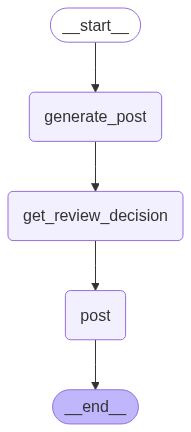

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [20]:
thread_config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

linkedin_topic = input("Enter your LinkedIn topic: ")
initial_state = {
    "linkedin_topic": linkedin_topic, 
    "generated_post": [], 
    "human_feedback": []
}

In [22]:
for chunk in app.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        #  If we reach an interrupt, continuously ask for human feedback

        if(node_id == "__interrupt__"):
            while True: 
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                response = app.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break

[generate_post] Generating content
[model_node] Generated post:
**The Future of Work: How AI is Revolutionizing the Job Market in 2025**

As we step into the new year, the rise of Artificial Intelligence (AI) continues to transform the job market like never before. According to recent studies, AI is expected to take over an estimated [X]% of jobs by 2025, a staggering 10% increase from 2023.

**What does this mean for professionals?**

While AI may seem like a threat to human employment, it's essential to understand that its primary role is to augment our capabilities, not replace them. In fact, AI can:

1. **Enhance productivity**: Automating repetitive tasks, freeing up time for more strategic and creative work.
2. **Improve decision-making**: Providing data-driven insights to support informed decisions.
3. **Upskill and reskill**: Enabling professionals to develop new skills and adapt to changing job requirements.

**The Top 5 Jobs That Will Thrive in an AI-Driven World**

1. **Data

In [32]:
print(response["generated_post"][4].content)

**The AI Revolution in Indian IT: Are Humans Ready to Adapt?**

As we step into 2025, the Indian IT industry is on the cusp of a significant transformation. Artificial Intelligence (AI) is no longer a distant dream, but a harsh reality that's taking over the job market. But what does this mean for the human workforce in India?

**The Current Landscape**

The Indian IT industry has been a driving force behind the country's economic growth, with a vast pool of skilled professionals and a thriving startup ecosystem. However, with AI taking center stage, there's a growing concern among IT professionals about job security and the future of employment.

**Key Statistics:**

*   By 2025, AI is expected to replace 32% of jobs in the Indian IT sector (Source: World Economic Forum)
*   India is projected to have over 1 million AI professionals by 2025, but the demand is expected to outstrip supply (Source: Nasscom)
*   AI adoption in Indian enterprises is expected to increase by 25% in the next 

In [31]:
print(response["generated_post"][5].content)

**The Future of Work: How Indian Companies are Adapting to the AI Revolution**

As we step into 2025, the job market is undergoing a significant transformation. Artificial Intelligence (AI) is increasingly becoming a crucial component of various industries, raising questions about the future of work. While some may fear the loss of jobs, others see this as an opportunity to upskill and reskill.

In India, several companies are at the forefront of this change, leveraging AI to enhance their operations and stay ahead in the competitive landscape. Here are a few examples:

1. **Tata Consultancy Services (TCS)**: TCS has been investing heavily in AI and automation to improve its services. The company has established an AI and Analytics Garages (AAG) network to foster innovation and collaboration among its employees. This initiative has helped TCS to develop AI-powered solutions for clients across various industries.
2. **Infosys**: Infosys has launched a program called 'NIA' (Newtonian Int